Lance Uy - 1006123570

# Homework 5: Part I

1. Go get data from kaggle.com and do a ***Bayesian Linear Regression*** analysis

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

2. Choose ***prior*** that are sensible: certainly you might change the ***hyperparameters***, and perhaps you can experiment with different distributional families for `sigma`...

3. [Optional] Assess the performance of the MCMC and note any issues or warnings

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Perform ***Multiple Linear Regression*** diagnostics... residual plots, etc.


In [6]:
import pymc as pm
import pandas as pd
import numpy as np
from scipy import stats
import random 

# Dataset about diabetes and factors that contribute to it
url = "https://raw.githubusercontent.com/LanceUy/STA365/main/diabetes.csv" 
df = pd.read_csv(url) 
random.seed(1006123570)

X = df[['Pregnancies', 'Glucose', 'BMI', 'Age']].values
y = df['Outcome'].values.reshape(-1, 1)

n, p = X.shape

with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p, 1)), cov=np.eye(p), shape=(p, 1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0)  # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


# Homework 5: Part II
    
## Answer the following with respect to $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ on the previous slide
    
1. Rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ in terms of $\sigma^2$ (no longer using $\Sigma$) if $\Sigma=\sigma^2I$

2. What is $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

3. What ***hyperparameters*** values (legal or illegal) would make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

4. What ***hyperparameters*** values (legal or illegal) would make $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

5. What is $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

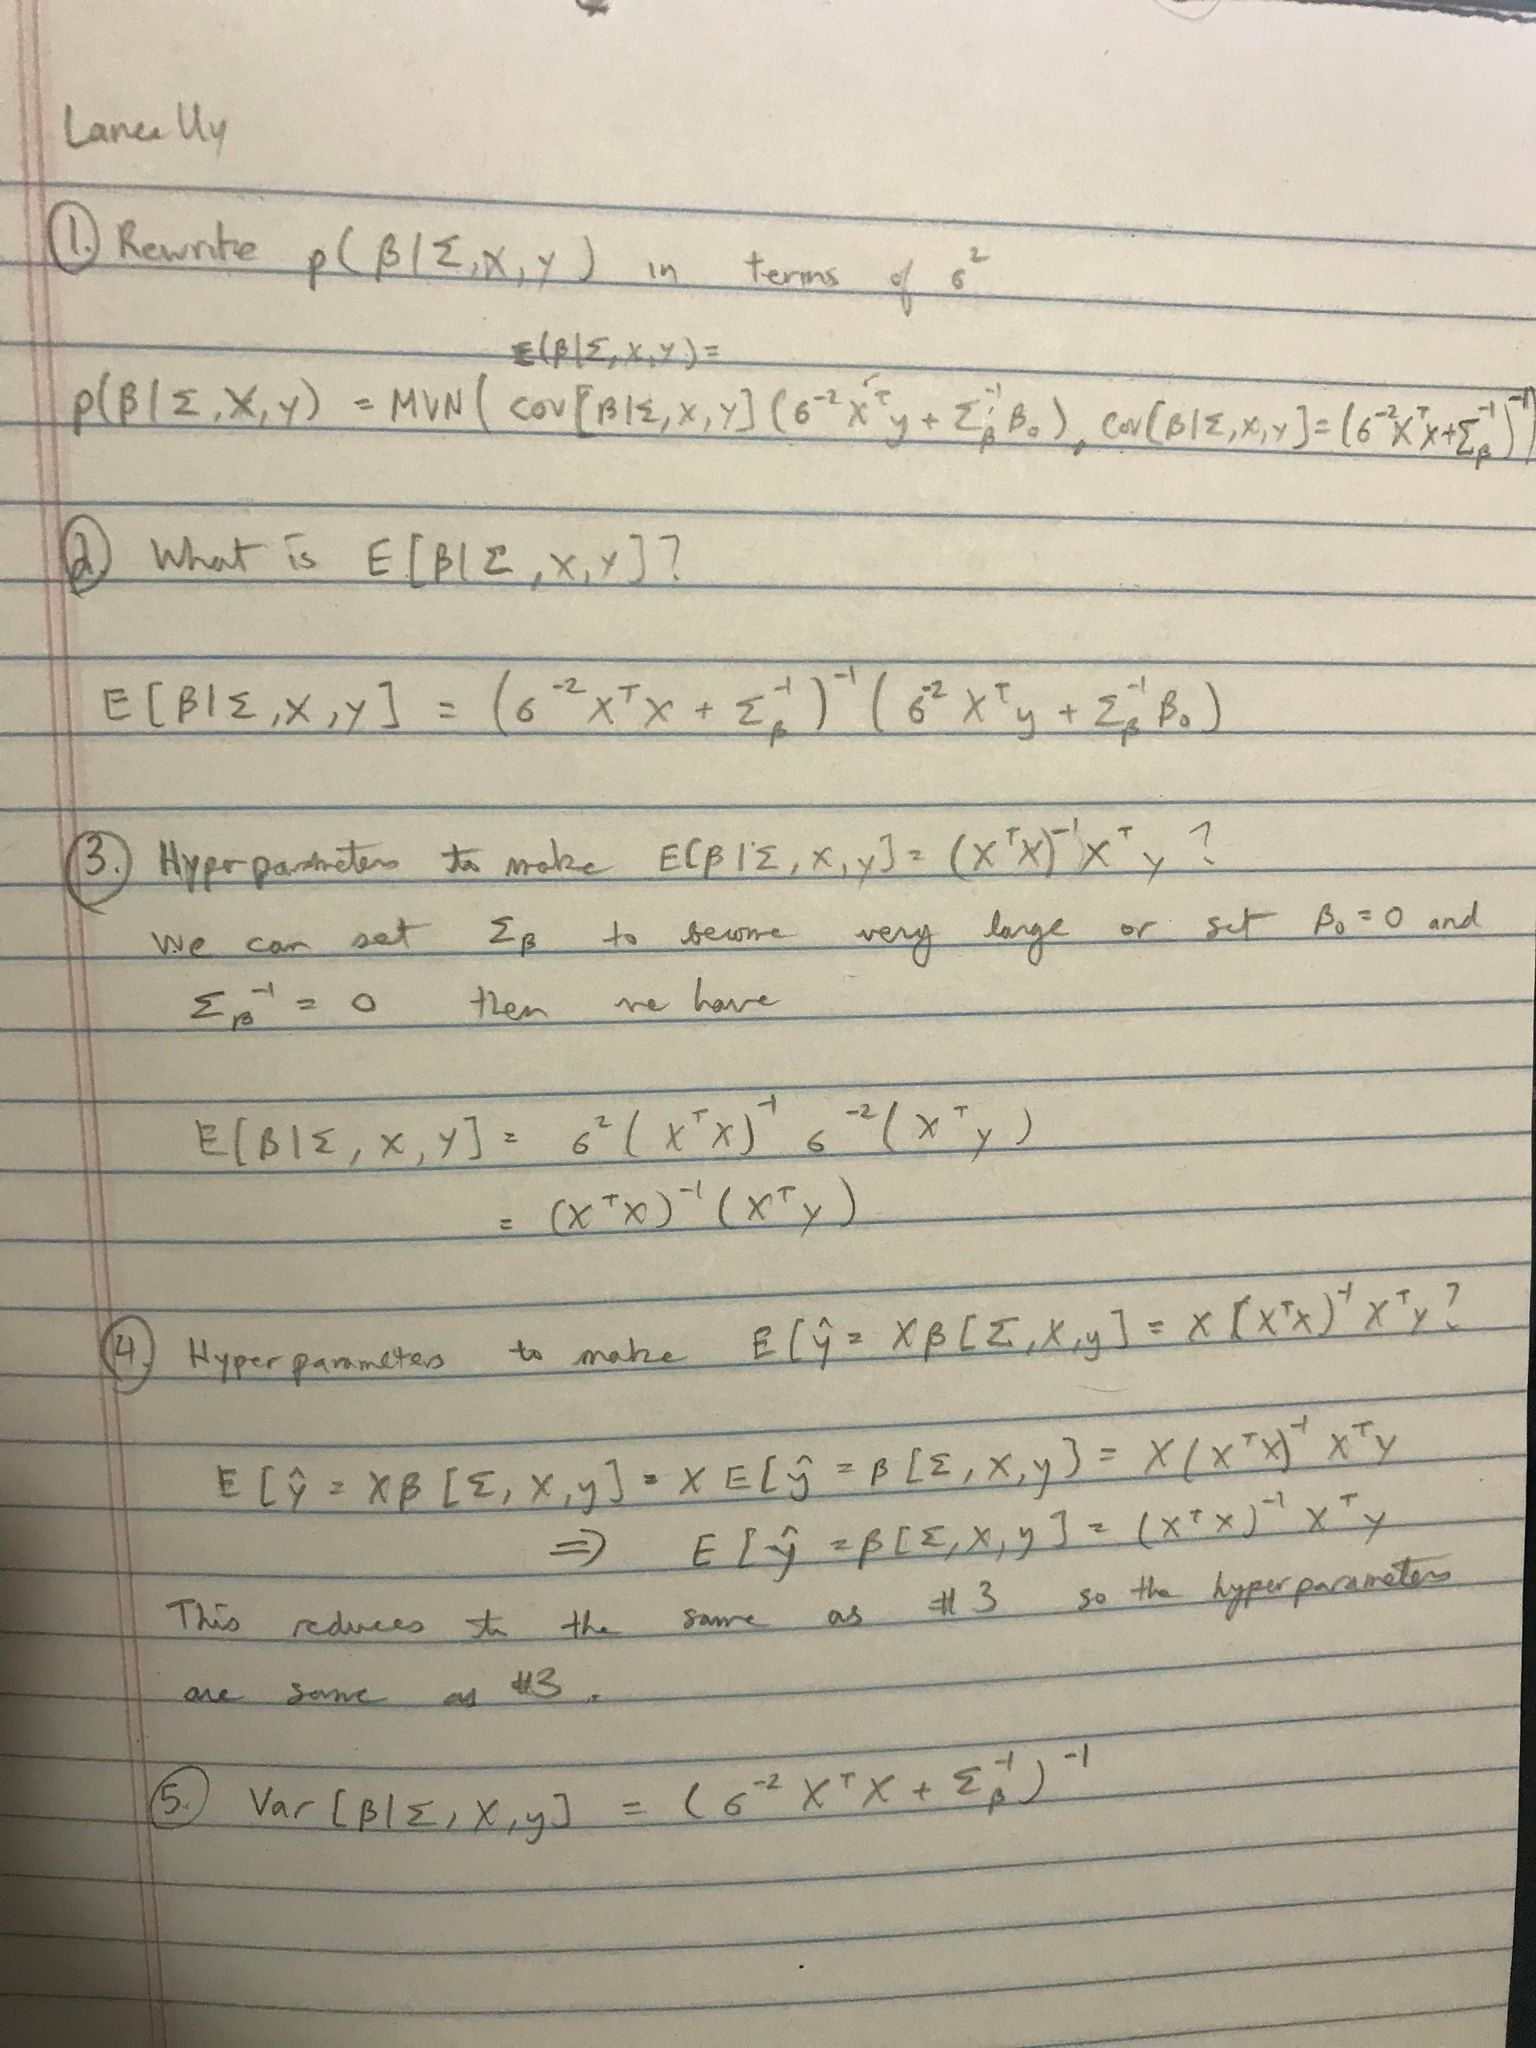

In [9]:
from IPython.display import Image

Image("hwk5p2.jpg", width=800, height=500)

# Homework 5: Part III

1. Go get data from kaggle.com and perform inference for a ***Bayesian Multivariate Normal Model***

<SPAN STYLE="font-size:9.0pt">

```python
import numpy as np; from scipy import stats
p=10; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
n=1000; y=stats.multivariate_normal(mean=np.zeros(p), cov=a_cov).rvs(size=n)
# Replace this made up data with your data set from kaggle...
    
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    # Sigma = pm.Deterministic('Sigma', L.dot(L.T)) # Don't use a covariance matrix parameterization
    mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p); 
    # y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=y) 
    # Figure out how to parameterize this with a Cholesky factor to improve computational efficiency 
with MNV_LKJ    
    idata = pm.sample()
```    
</SPAN>

2. As indicated above, don't use a covariance matrix parameterization and instead figure out how to parameterize this with a ***Cholesky factor*** to improve computational efficiency. The ***Cholesky***-based formulation allows general $O(n^3)$ $\det({\boldsymbol \Sigma})$ to be computed using a simple $O(n)$ product and general $O(n^3)$ ${\boldsymbol \Sigma}^{-1}$ to be instead evaluated with $O(n^2)$ ***backward substitution***. 

2. Specify ***priors*** that work: certainly you'll likely need to change the ***prior hyperparameters*** for $\boldsymbol \mu$ (`mu`) and $\mathbf{R}$ (`packed_L`)...
    1. And you could consider adjusting the ***prior*** for $\boldsymbol \sigma$ using `sd_dist`... 

3. [Optional] Assess the performance of the MCMC and note any issues

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)



In [8]:
import pymc as pm
import pandas as pd
import numpy as np
from scipy import stats
import random 

url = "https://raw.githubusercontent.com/LanceUy/STA365/main/diabetes.csv" 
df = pd.read_csv(url) 
random.seed(1006123570)

features = ['Pregnancies', 'Glucose', 'BMI', 'Age']

# Extracting y from the DataFrame
y = df[features].values

# Only extract the number of features (m) for the shape parameter in mu
p = len(features)
    
with pm.Model() as MNV_LKJ:
    mu = pm.Normal('mu', mu=0, sigma=10, shape=p)
    sd_dist = pm.HalfNormal.dist(sigma=2.5, shape=p)
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=p, eta=2.0,
                                 sd_dist=sd_dist, compute_corr=True)

    new_y = pm.MvNormal('new_y', mu=mu, chol=chol, observed=y) 

with MNV_LKJ:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
